# Lab Besos Work Flow from idf to surrogate desgin optimization


In this laboratory you will go over some of the basic work flow to create a a surrogate design optimization model from an EnergyPlus simulation. You will train a surrogate model network to find optimal design parameters.

In [ ]:
#!pip install besos --user
%matplotlib inline
import time
import numpy as np
import pandas as pd

from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP, EvaluatorGeneric
from besos.parameters import RangeParameter, FieldSelector, Parameter
from besos.problem import EPProblem, Problem
from besos import eppy_funcs as ef, sampling
from besos.optimizer import NSGAII

from epw import epw

import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from plotly import express as px
import plotly

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import mean_squared_error, r2_score

import plotly
import plotly.express as px

2025-12-10 09:41:25.330046: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-12-10 09:41:25.330100: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Couldn't import dot_parser, loading of dot files will not be possible.


# Building presentation

In this Laboratory you will have to perform a surrogate optimization of a sample residential building unit. The considered unit is composed by a typical flat of a multi-storey building. Its internal organisation and definition is in line with suggested residential building typologies included in well-known architectural technical manuals  The considered building is composed by two units for floor, while a single unit is simulated for this chapter. The simulated spaces are considered to be at an intermediate floor with an upper floor and lower floor working at the same temperature (adiabatic). Similarly, the simulated unit is touching a specular one: confining walls are also assumed as adiabatic. Upper-floor balconies are included to consider shading effects.

![Image](image/building_lab.png)

## Load the Building 

The building is defined by the Information Data File (IDF) or using the new EnergyPlus format (IDF).

In [2]:
# Open the IDF file
idf_file = 'Res-Flat2_IDF_9.6_modified.idf'
building = ef.get_building(idf_file)

#building.view_model()

## Evaluator
## Set up the inputs and outputs of your exploration

- what properties of the building will we be changing?
- what are some of the performance metrics of the building that we want to explore?
- what external weather conditions is the building experiencing?


![Image](image/setting_up_the_evaluator.PNG)

### Load and Display Weather Data

In [3]:
# The weather conditions are specified in the EnergyPlus Weather File (EWP) file. The properties we will change in the building will be defined in the parameter space. In the objectives we will specify the what output performance metrics we wish to extract such that we can explore them later.

weather_data = epw()
epw_file = "PARIS_FR-hour.epw"
weather_data.read(epw_file)

weather_data.dataframe

Year  Month  Day  Hour  Minute  \
0     2005      1    1     1      60   
1     2005      1    1     2      60   
2     2005      1    1     3      60   
3     2005      1    1     4      60   
4     2005      1    1     5      60   
...    ...    ...  ...   ...     ...   
8755  2005     12   31    20      60   
8756  2005     12   31    21      60   
8757  2005     12   31    22      60   
8758  2005     12   31    23      60   
8759  2005     12   31    24      60   

                 Data Source and Uncertainty Flags  Dry Bulb Temperature  \
0     *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                   0.2   
1     *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                  -0.2   
2     *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                  -0.6   
3     *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                  -0.8   
4     *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                  -1.1   
...                                            ...                   ...   
8755  *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                   1.2   
8756  *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                   0.9   
8757  *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                   0.6   
8758  *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                   0.1   
8759  *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                   0.1   

      Dew Point Temperature  Relative Humidity  Atmospheric Station Pressure  \
0                      -7.4                 56                        101164   
1                      -7.4                 58                        101164   
2                      -7.9                 57                        101164   
3                      -8.1                 58                        101164   
4                      -8.4                 57                        101164   
...                     ...                ...                           ...   
8755                   -1.7                 81                        100678   
8756                   -2.1                 80                        100689   
8757                   -2.9                 77                        100700   
8758                   -1.7                 88                        100711   
8759                   -1.5                 89                        100722   

      ...  Ceiling Height  Present Weather Observation  Present Weather Codes  \
0     ...           99999                            9              999999999   
1     ...           99999                            9              999999999   
2     ...           99999                            9              999999999   
3     ...           99999                            9              999999999   
4     ...           99999                            9              999999999   
...   ...             ...                          ...                    ...   
8755  ...           99999                            9              999999999   
8756  ...           99999                            9              999999999   
8757  ...           99999                            9              999999999   
8758  ...           99999                            9              999999999   
8759  ...           99999                            9              999999999   

      Precipitable Water  Aerosol Optical Depth  Snow Depth  \
0                      6                  0.094           1   
1                      6                  0.094           1   
2                      5                  0.094           1   
3                      5                  0.094           1   
4                      5                  0.094           1   
...                  ...                    ...         ...   
8755                   8                  0.101           0   
8756                   8                  0.101           0   
8757                   8                  0.101           0   
8758                   8                  0.101 

In [4]:
weather_data.dataframe.describe()

Year        Month          Day         Hour  Minute  \
count  8760.0  8760.000000  8760.000000  8760.000000  8760.0   
mean   2005.0     6.526027    15.720548    12.500000    60.0   
std       0.0     3.448048     8.796749     6.922582     0.0   
min    2005.0     1.000000     1.000000     1.000000    60.0   
25%    2005.0     4.000000     8.000000     6.750000    60.0   
50%    2005.0     7.000000    16.000000    12.500000    60.0   
75%    2005.0    10.000000    23.000000    18.250000    60.0   
max    2005.0    12.000000    31.000000    24.000000    60.0   

       Dry Bulb Temperature  Dew Point Temperature  Relative Humidity  \
count           8760.000000            8760.000000        8760.000000   
mean              13.459167               7.302180          67.973630   
std                6.417562               5.387262          14.378834   
min               -1.900000              -8.800000          27.000000   
25%                8.700000               3.500000          57.000000   
50%               13.200000               7.400000          68.000000   
75%               18.300000              11.200000          79.000000   
max               33.200000              22.800000         100.000000   

       Atmospheric Station Pressure  Extraterrestrial Horizontal Radiation  \
count                   8760.000000                            8760.000000   
mean                  100858.916324                             289.739269   
std                      272.243386                             374.530939   
min                   100069.000000                               0.000000   
25%                   100661.000000                               0.000000   
50%                   100849.000000                              16.000000   
75%                   101066.000000                             546.000000   
max                   101547.000000                            1190.000000   

       ...  Ceiling Height  Present Weather Observation  \
count  ...          8760.0                       8760.0   
mean   ...         99999.0                          9.0   
std    ...             0.0                          0.0   
min    ...         99999.0                          9.0   
25%    ...         99999.0                          9.0   
50%    ...         99999.0                          9.0   
75%    ...         99999.0                          9.0   
max    ...         99999.0                          9.0   

       Present Weather Codes  Precipitable Water  Aerosol Optical Depth  \
count                 8760.0         8760.000000            8760.000000   
mean             999999999.0           16.600685               0.174258   
std                      0.0            6.329907               0.060578   
min              999999999.0            5.000000               0.039000   
25%              999999999.0           12.000000               0.126000   
50%              999999999.0           16.000000               0.181000   
75%              999999999.0           20.000000               0.218000   
max              999999999.0           46.000000               0.338000   

        Snow Depth  Days Since Last Snowfall       Albedo  \
count  8760.000000               8760.000000  8760.000000   
mean      0.015183                 74.213014     0.201285   
std       0.184135                 26.073199     0.017504   
min       0.000000                  0.000000     0.200000   
25%       0.000000                 76.000000     0.200000   
50%       0.000000                 88.000000     0.200000   
75%       0.000000                 88.000000     0.200000   
max       3.000000                 88.000000     0.607000   

       Liquid Precipitation Depth  Liquid Precipitation Quantity  
count                 8760.000000                         8760.0  
mean                     0.051541                           99.0  
std                      0.314345                            0.0  
min                      0.000000            

# Define The Problem

1. Define the parameters and your objectives you whant to change
2. Create Selectors for getting the parameters fileds in the model
3. Describe the parameter variation
4. Define your problem

- Print the elements we want to optimize

In [5]:
building.idfobjects['MATERIAL']

[
Material,
    Cast Concrete (Dense)_.1,    !- Name
    Rough,                    !- Roughness
    0.1,                      !- Thickness
    1.4,                      !- Conductivity
    2100,                     !- Density
    840,                      !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
, 
Material,
    Asphalt 1_.01,            !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.7,                      !- Conductivity
    2100,                     !- Density
    1000,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.85,                     !- Solar Absorptance
    0.9;                      !- Visible Absorptance
, 
Material,
    MW Glass Wool (rolls)_.0001,    !- Name
    Rough,                    !- Roughness
    0.0001,                   !- Thickness

In [6]:
for elm in building.idfobjects['FENESTRATIONSURFACE:DETAILED']:
    # there are doors, so filter them to extract the windows
    if elm.Surface_Type == 'Window':
        print(elm)


FenestrationSurface:Detailed,
    StairXnoHVAC:Zona1_Wall_2_0_0_0_0_0_Win,    !- Name
    Window,                   !- Surface Type
    simple_glazing_window,    !- Construction Name
    StairXnoHVAC:Zona1_Wall_2_0_0,    !- Building Surface Name
    ,                         !- Outside Boundary Condition Object
    AutoCalculate,            !- View Factor to Ground
    1,                        !- Frame and Divider Name
    1,                        !- Multiplier
    4,                        !- Number of Vertices
    3.5,                      !- Vertex 1 Xcoordinate
    5.615,                    !- Vertex 1 Ycoordinate
    0.84,                     !- Vertex 1 Zcoordinate
    3.5,                      !- Vertex 2 Xcoordinate
    6.135,                    !- Vertex 2 Ycoordinate
    0.84,                     !- Vertex 2 Zcoordinate
    3.5,                      !- Vertex 3 Xcoordinate
    6.135,                    !- Vertex 3 Ycoordinate
    2.26,                     !- Vertex 3 Zcoor

In [7]:
building.idfobjects["WINDOWSHADINGCONTROL"]

[
WindowShadingControl,
    11001,                    !- Name
    StairXnoHVAC:Zona1,       !- Zone Name
    ,                         !- Shading Control Sequence Number
    ExteriorBlind,            !- Shading Type
    simple_glazing_window_with_blind,    !- Construction with Shading Name
    OnIfHighOutdoorAirTempAndHighHorizontalSolar,    !- Shading Control Type
    Summer (Northern Hemisphere),    !- Schedule Name
    24,                       !- Setpoint
    Yes,                      !- Shading Control Is Scheduled
    No,                       !- Glare Control Is Active
    20002,                    !- Shading Device Material Name
    FixedSlatAngle,           !- Type of Slat Angle Control for Blinds
    ,                         !- Slat Angle Schedule Name
    120,                      !- Setpoint 2
    ,                         !- Daylighting Control Object Name
    Group,                    !- Multiple Surface Control Type
    StairXnoHVAC:Zona1_Wall_2_0_0_0_0_0_Win;    !- Fen

In [8]:
building.idfobjects['ZONEVENTILATION:DESIGNFLOWRATE']

[
ZoneVentilation:DesignFlowRate,
    Flat2:Zona3 Nat Vent,     !- Name
    Flat2:Zona3,              !- Zone or ZoneList Name
    Summer (Northern Hemisphere),    !- Schedule Name
    AirChanges/Hour,          !- Design Flow Rate Calculation Method
    0.016649,                 !- Design Flow Rate
    ,                         !- Flow Rate per Zone Floor Area
    ,                         !- Flow Rate per Person
    1,                        !- Air Changes per Hour
    NATURAL,                  !- Ventilation Type
    0,                        !- Fan Pressure Rise
    1,                        !- Fan Total Efficiency
    1,                        !- Constant Term Coefficient
    0,                        !- Temperature Term Coefficient
    0,                        !- Velocity Term Coefficient
    0,                        !- Velocity Squared Term Coefficient
    18,                       !- Minimum Indoor Temperature
    ,                         !- Minimum Indoor Temperature Schedul

- Create FieldSelectors and Parameters

In [9]:
parameters = []

# 1) Thermal insulation thickness - walls
insulation_wall_selector = FieldSelector(class_name='Material', object_name='_Insulation_.0001', field_name='Thickness')
wall_range = RangeParameter(min_val=0.01, max_val=0.25)

insulation_wall_param = Parameter(
    selector=insulation_wall_selector,
    value_descriptor=wall_range,
    name='Insulation Wall Thickness'
)

parameters.append(insulation_wall_param)

/opt/conda/envs/myenv/lib/python3.9/site-packages/besos/parameters.py:424: FutureWarning: Use value_descriptors instead of value_descriptor.
  warnings.warn(


In [10]:
# 2) Thermal insulation thickness - roofs
insulation_roof_selector = FieldSelector(class_name='Material', object_name='MW Glass Wool (rolls)_.0001', field_name='Thickness')
roof_range = RangeParameter(min_val=0.01, max_val=0.50)

insulation_roof_param = Parameter(
    selector=insulation_roof_selector,
    value_descriptor=roof_range,
    name='Insulation Roof Thickness'
)

parameters.append(insulation_roof_param)

In [11]:
# 3) Window types: U-Factor, SHGC and VT

# - U-Factor (Glazing Heat Loss)
# Range from 0.8 (triple pane/high performance) to 5.0 (single pane)
u_factor_range = RangeParameter(min_val=0.8, max_val=5.0)
u_factor_selector = FieldSelector(
    class_name='WindowMaterial:SimpleGlazingSystem',
    object_name='*',
    field_name='U-Factor'
)
u_factor_param = Parameter(
    selector=u_factor_selector,
    value_descriptors=u_factor_range,
    name='Glazing - U-Factor (W/m2-K)'
)

parameters.append(u_factor_param)

# - Solar Heat Gain Coefficient (SHGC)
# Range from 0.3 (low solar gain) to 0.8 (high solar gain)
shgc_range = RangeParameter(min_val=0.3, max_val=0.8)
shgc_selector = FieldSelector(
    class_name='WindowMaterial:SimpleGlazingSystem',
    object_name='*',
    field_name='Solar Heat Gain Coefficient'
)
shgc_param = Parameter(
    selector=shgc_selector,
    value_descriptors=shgc_range,
    name='Glazing - SHGC'
)

parameters.append(shgc_param)

# Visible Transmittance (VT)
# Range from 0.3 to 0.8
visible_transmittance_range = RangeParameter(min_val=0.3, max_val=0.8)
visible_transmittance_selector = FieldSelector(
    class_name='WindowMaterial:SimpleGlazingSystem',
    object_name='*',
    field_name='Visible Transmittance'
)
visible_transmittance_param = Parameter(
    selector=visible_transmittance_selector,
    value_descriptors=visible_transmittance_range,
    name='Glazing - Visible Transmittance'
)

parameters.append(visible_transmittance_param)

In [12]:
# 4) Shading thresholds: temperature + global horizontal irradiation

# - temperature
TempShadingRange = RangeParameter(min_val=18, max_val=30)
shade_temp_selector = FieldSelector(
    class_name='WindowShadingControl',
    object_name='*',
    field_name='Setpoint'
)
shade_temp_param = Parameter(
    selector=shade_temp_selector,
    value_descriptor=TempShadingRange,
    name='Temp Setpoint shading'
)
parameters.append(shade_temp_param)

# - global horizontal irradiation
RadShadingRange = RangeParameter(min_val=80, max_val=300)
shade_rad_selector = FieldSelector(
    class_name='WindowShadingControl',
    object_name='*',
    field_name='Setpoint 2'
)
shade_rad_param = Parameter(
    selector=shade_rad_selector,
    value_descriptor=RadShadingRange,
    name='Rad Setpoint shading'
)
parameters.append(shade_rad_param)

In [13]:
# 5) Natural ventilation thresholds: Tin.Min, Tin. Max 

TinMinRange = RangeParameter(min_val=10.0, max_val=20.0)
TinMaxRange = RangeParameter(min_val=15.0, max_val=35.0)

# - Tin. Min (Minimum Indoor Temperature)
vent_tin_min_selector = FieldSelector(
    class_name = 'ZoneVentilation:DesignFlowRate',
    object_name = '*',
    field_name = 'Minimum Indoor Temperature'
)
vent_tin_min_param = Parameter(
    selector=vent_tin_min_selector, 
    value_descriptor=TinMinRange,
    name='Ventilation Min Tin Threshold'
)
parameters.append(vent_tin_min_param)

# - Tin. Max (Maximum Indoor Temperature)
vent_tin_max_selector = FieldSelector(
    class_name = 'ZoneVentilation:DesignFlowRate',
    object_name = '*',
    field_name = 'Maximum Indoor Temperature'
)
vent_tin_max_param = Parameter(
    selector=vent_tin_max_selector, 
    value_descriptor=TinMaxRange,
    name='Ventilation Max Tin Threshold'
)
parameters.append(vent_tin_max_param)

In [14]:
# 6) Natural ventilation ACH (Air Changes per Hour)
ventAchRange = RangeParameter(min_val=0.0, max_val=6.0)

ventACH_selector = FieldSelector(
    class_name = 'ZoneVentilation:DesignFlowRate',
    object_name = '*',
    field_name = 'Air Changes per Hour'
)
ventilationACH_param = Parameter(
    selector=ventACH_selector, 
    value_descriptors=ventAchRange,
    name='Ventilation ACH'
)

parameters.append(ventilationACH_param)

In [15]:
# 7) Lighting intensity
lights_range = RangeParameter(min_val=2, max_val=6)

lights_selector = FieldSelector(
    class_name='Lights',
    object_name='*',
    field_name='Watts per Zone Floor Area'
)

lights_param = Parameter(
    lights_selector,
    value_descriptors=lights_range,
    name="Lights Watts/Area"
)
parameters.append(lights_param)

In [16]:
# Print parameters
print("\nAll parameters:")
for i in range(len(parameters)):
    print(f" {i}) {parameters[i].name}")


All parameters:
 0) Insulation Wall Thickness
 1) Insulation Roof Thickness
 2) Glazing - U-Factor (W/m2-K)
 3) Glazing - SHGC
 4) Glazing - Visible Transmittance
 5) Temp Setpoint shading
 6) Rad Setpoint shading
 7) Ventilation Min Tin Threshold
 8) Ventilation Max Tin Threshold
 9) Ventilation ACH
 10) Lights Watts/Area


/tmp/ipykernel_22/2951783100.py:4: DeprecationWarning: Call to deprecated function (or staticmethod) name. (Parameters are no longer nameable. Use the name(s) of this Parameter's Descriptor(s) instead) -- Deprecated since version 2.0.0.
  print(f" {i}) {parameters[i].name}")


- Define the problem

In [17]:
objectives = [
    'Electricity:Facility', # light inside
    'DistrictHeating:Facility',
    'DistrictCooling:Facility'
] # these get made into `MeterReader` or `VariableReader`
# cannot sum them -> NEVER sum it

problem = EPProblem(parameters, objectives) # problem = parameters + objectives

problem.names()

['Insulation Wall Thickness',
 'Insulation Roof Thickness',
 'Glazing - U-Factor (W/m2-K)',
 'Glazing - SHGC',
 'Glazing - Visible Transmittance',
 'Temp Setpoint shading',
 'Rad Setpoint shading',
 'Ventilation Min Tin Threshold',
 'Ventilation Max Tin Threshold',
 'Ventilation ACH',
 'Lights Watts/Area',
 'Electricity:Facility',
 'DistrictHeating:Facility',
 'DistrictCooling:Facility']

## Generate the Dataset

1. Generate 20 samples with sampling strategy
2. Setup the parallel processing
3. Simulate the Samples
4. Store and recover the expensive runs

In [18]:
number_of_samples = 40 # can increase it if we have dependency issues
samples = sampling.dist_sampler(sampling.lhs, problem, num_samples=number_of_samples)
samples

Insulation Wall Thickness  Insulation Roof Thickness  \
0                    0.108109                   0.211034   
1                    0.023301                   0.390200   
2                    0.202665                   0.336390   
3                    0.168836                   0.385769   
4                    0.185388                   0.475733   
5                    0.178084                   0.405839   
6                    0.035902                   0.141994   
7                    0.216215                   0.495510   
8                    0.174546                   0.262383   
9                    0.233542                   0.286219   
10                   0.082717                   0.367399   
11                   0.209932                   0.233725   
12                   0.129221                   0.443418   
13                   0.105378                   0.243136   
14                   0.227252                   0.147424   
15                   0.116536                   0.051691   
16                   0.079748                   0.223958   
17                   0.197707                   0.111253   
18                   0.240551                   0.304272   
19                   0.136861                   0.043332   
20                   0.119513                   0.181294   
21                   0.044632                   0.438334   
22                   0.142078                   0.059848   
23                   0.052532                   0.426083   
24                   0.071929                   0.294685   
25                   0.014440                   0.017558   
26                   0.151941                   0.033224   
27                   0.244996                   0.471739   
28                   0.019224                   0.086242   
29                   0.028922                   0.075859   
30                   0.069589                   0.195693   
31                   0.131378                   0.452587   
32                   0.093221                   0.322411   
33                   0.094367                   0.277494   
34                   0.194753                   0.362977   
35                   0.223635                   0.131284   
36                   0.051486                   0.096159   
37                   0.058673                   0.349099   
38                   0.159844                   0.158071   
39                   0.161256                   0.193037   

    Glazing - U-Factor (W/m2-K)  Glazing - SHGC  \
0                      3.898389        0.761052   
1                      3.017668        0.693758   
2                      4.536036        0.385825   
3                      3.401928        0.747669   
4                      2.233961        0.319887   
5                      1.046873        0.343937   
6                      3.450890        0.686972   
7                      2.723088        0.550877   
8                      4.672902        0.389617   
9                      1.238240        0.613804   
10                     4.707981        0.717791   
11                     2.683718        0.366133   
12                     2.324312        0.517657   
13                     3.800110        0.426875   
14                     4.432428        0.533290   
15                     1.514939        0.598080   
16                     0.820222        0.457538   
17                     1.967111        0.579766   
18                     1.568933        0.400242   
19                     3.267607        0.639443   
20                     1.770998        0.307940   
21                     3.952130        0.770548   
22                     4.891041        0.476397   
23                     1.682863        0.506823   
24                     4.903124        0.708297   
25                     1.888665        0.544779   
26                     3.002637        0.777731   
27                     3.568940        0.415381   
28                     4.161010        0.350515   
29           

In [19]:
evaluator = EvaluatorEP(
    problem, 
    building, 
    out_dir='outputdir',
    err_dir='outputdir',
    epw_file=epw_file,
    progress_bar=True
)

/opt/conda/envs/myenv/lib/python3.9/site-packages/besos/evaluator.py:672: FutureWarning: epw_file has been deprecated and will be removed in the future. Use epw instead.
  warn(


Run the samples and calculate the execution time

In [20]:
# Run Energyplus
t1 = time.time()

sim_samples = evaluator.df_apply(
    samples,
    keep_input=True, # keep the input data in the results
    #keep_dirs=True, # save all ouput
    processes=2
)  

t2 = time.time()
time_of_sim = t2 - t1

EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:41
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:41
Initializing Response Factors
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Window Optical Properties
Initializing Solar Calculations
Initializing Solar Calculations
Allocate Solar Module Arrays
A

Could not find platform independent libraries <prefix>
Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Temperature and Flux Histories
Initializing Window Shading
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Initializing Interior Convec

EnergyPlus Completed Successfully.
EnergyPlus Completed Successfully.


Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min 10.42sec
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:43
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:43
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains


EnergyPlus Completed Successfully.


Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min  9.71sec


EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:45
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:45
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Warming up
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Warming up
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Repor

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN SEN

EnergyPlus Completed Successfully.


Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min 10.79sec


EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:47
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Calculating Detailed Daylighting Factors, Start Date=06/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Wa

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializ

EnergyPlus Completed Successfully.


Updating Shadowing Calculations, Start Date=03/22/2002
Updating Detailed Daylighting Factors, Start Date=03/22
Continuing Simulation at 03/22/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=04/11/2002
Updating Detailed Daylighting Factors, Start Date=04/11
Continuing Simulation at 04/11/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=05/01/2002
Updating Detailed Daylighting Factors, Start Date=05/01
Continuing Simulation at 05/01/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=05/21/2002
Updating Detailed Daylighting Factors, Start Date=05/21
Continuing Simulation at 05/21/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=06/10/2002
Updating Detailed Daylighting Factors, Start Date=06/10
Continuing Simulation at 06/10/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=06/30/2002
Updating Detailed Daylighting Factors, Start Date=06/30

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:48
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computin

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...fo

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:48
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Perfor

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:50
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warmin

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:50
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=06/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:51
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Calculating Detailed Daylighting Factors, Start Date=06/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Wa

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:52
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computin

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Perfor

EnergyPlus Completed Successfully.


Updating Shadowing Calculations, Start Date=12/27/2002
Updating Detailed Daylighting Factors, Start Date=12/27
Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min 11.32sec
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:53
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar 

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:53
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simul

EnergyPlus Completed Successfully.


Updating Shadowing Calculations, Start Date=10/28/2002
Updating Detailed Daylighting Factors, Start Date=10/28
Continuing Simulation at 10/28/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=11/17/2002
Updating Detailed Daylighting Factors, Start Date=11/17
Continuing Simulation at 11/17/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/07/2002
Updating Detailed Daylighting Factors, Start Date=12/07
Continuing Simulation at 12/07/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/27/2002
Updating Detailed Daylighting Factors, Start Date=12/27
Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min 10.82sec
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:54
Initializing Response Factors
Calculating CTFs for "PAVIMENT

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN SENZA TITOLO (

EnergyPlus Completed Successfully.


Updating Shadowing Calculations, Start Date=12/07/2002
Updating Detailed Daylighting Factors, Start Date=12/07
Continuing Simulation at 12/07/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/27/2002
Updating Detailed Daylighting Factors, Start Date=12/27
Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min 11.05sec
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:55
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate S

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=06/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DES

EnergyPlus Completed Successfully.


Updating Shadowing Calculations, Start Date=12/07/2002
Updating Detailed Daylighting Factors, Start Date=12/07
Continuing Simulation at 12/07/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/27/2002
Updating Detailed Daylighting Factors, Start Date=12/27
Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min 11.03sec
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:56
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate S

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SU

EnergyPlus Completed Successfully.
Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:57
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:58
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Comp

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN SEN

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:58
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Calculating Detailed Daylighting Factors, Start Date=06/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Wa

EnergyPlus Completed Successfully.


Updating Detailed Daylighting Factors, Start Date=12/07
Continuing Simulation at 12/07/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/27/2002
Updating Detailed Daylighting Factors, Start Date=12/27
Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min 10.31sec
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 09:59
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Repo

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 10:00
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Comp

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Calculating Detailed Daylighting Factors, Start Date=06/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Wa

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 10:01
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Comp

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warmin

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 10:02
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SU

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 10:03
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 10:03
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simul

EnergyPlus Completed Successfully.


Updating Detailed Daylighting Factors, Start Date=12/07
Continuing Simulation at 12/07/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/27/2002
Updating Detailed Daylighting Factors, Start Date=12/27
Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min 11.14sec
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 10:04
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Repo

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone S

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 10:05
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Comp

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simul

EnergyPlus Completed Successfully.


Updating Shadowing Calculations, Start Date=12/07/2002
Updating Detailed Daylighting Factors, Start Date=12/07
Continuing Simulation at 12/07/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/27/2002
Updating Detailed Daylighting Factors, Start Date=12/27
Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min 10.48sec
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 10:06
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate S

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone S

EnergyPlus Completed Successfully.


Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min  9.84sec
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 10:07
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Init

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SU

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 10:08
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Perfor

EnergyPlus Completed Successfully.


Updating Detailed Daylighting Factors, Start Date=11/17
Continuing Simulation at 11/17/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/07/2002
Updating Detailed Daylighting Factors, Start Date=12/07
Continuing Simulation at 12/07/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/27/2002
Updating Detailed Daylighting Factors, Start Date=12/27
Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min  9.90sec
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 10:08
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTF

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SU

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 10:09


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains


EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 10:10
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Comp

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Updating Shadowing Calculations, Start Date=01/21/2002
Updating Detailed Daylighting Factors, Start Date=01/21
Continuing Simulation at 01/21/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=02/10/2002
Updating Detailed Daylighting Factors, Start Date=02/10
Continuing Simulation at 02/10/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=03/02/2002
Updating Detailed Daylighting Factors, Start Date=03/02
Continuing Simulation at 03/02/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=03/22/2002
Updating Detailed Daylighting Factors, Start Date=03/22
Continuing Simulation at 03/22/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=04/11/2002
Updating Detailed Daylighting Factors, Start Date=04/11
Continuing Simulation at 04/11/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=05/01/2002
Updating Detailed Daylighting Factors, Start Date=05/01

EnergyPlus Completed Successfully.


Updating Shadowing Calculations, Start Date=10/28/2002
Updating Detailed Daylighting Factors, Start Date=10/28
Continuing Simulation at 10/28/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=11/17/2002
Updating Detailed Daylighting Factors, Start Date=11/17
Continuing Simulation at 11/17/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/07/2002
Updating Detailed Daylighting Factors, Start Date=12/07
Continuing Simulation at 12/07/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/27/2002
Updating Detailed Daylighting Factors, Start Date=12/27
Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min  9.73sec
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 10:11
Initializing Response Factors
Calculating CTFs for "PAVIMENT

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Perfor

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 10:11
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computin

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warmin

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 10:12
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Perfor

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.10 10:13
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computin

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warmin

EnergyPlus Completed Successfully.


Calculate the time

In [21]:
def niceformat(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return hour, minutes, seconds

hours, mins, secs = niceformat(time_of_sim)

print(
    "The total running time: {:2.0f} hours {:2.0f} min {:2.0f} seconds".format(
        hours, mins, secs
    )
)

The total running time:  0 hours 33 min 24 seconds


## Store the expensive calculations

Since this can quite a big run. Lets store the results such that we don't have to rerun this problem.

In [22]:

sim_samples.to_pickle(f"simulation_results_{number_of_samples}.pkl")
sim_samples.to_csv(f'simulation_results_{number_of_samples}.csv', index=False)

## Analize and describe your simulation output

In [23]:
sim_samples

Insulation Wall Thickness  Insulation Roof Thickness  \
0                    0.108109                   0.211034   
1                    0.023301                   0.390200   
2                    0.202665                   0.336390   
3                    0.168836                   0.385769   
4                    0.185388                   0.475733   
5                    0.178084                   0.405839   
6                    0.035902                   0.141994   
7                    0.216215                   0.495510   
8                    0.174546                   0.262383   
9                    0.233542                   0.286219   
10                   0.082717                   0.367399   
11                   0.209932                   0.233725   
12                   0.129221                   0.443418   
13                   0.105378                   0.243136   
14                   0.227252                   0.147424   
15                   0.116536                   0.051691   
16                   0.079748                   0.223958   
17                   0.197707                   0.111253   
18                   0.240551                   0.304272   
19                   0.136861                   0.043332   
20                   0.119513                   0.181294   
21                   0.044632                   0.438334   
22                   0.142078                   0.059848   
23                   0.052532                   0.426083   
24                   0.071929                   0.294685   
25                   0.014440                   0.017558   
26                   0.151941                   0.033224   
27                   0.244996                   0.471739   
28                   0.019224                   0.086242   
29                   0.028922                   0.075859   
30                   0.069589                   0.195693   
31                   0.131378                   0.452587   
32                   0.093221                   0.322411   
33                   0.094367                   0.277494   
34                   0.194753                   0.362977   
35                   0.223635                   0.131284   
36                   0.051486                   0.096159   
37                   0.058673                   0.349099   
38                   0.159844                   0.158071   
39                   0.161256                   0.193037   

    Glazing - U-Factor (W/m2-K)  Glazing - SHGC  \
0                      3.898389        0.761052   
1                      3.017668        0.693758   
2                      4.536036        0.385825   
3                      3.401928        0.747669   
4                      2.233961        0.319887   
5                      1.046873        0.343937   
6                      3.450890        0.686972   
7                      2.723088        0.550877   
8                      4.672902        0.389617   
9                      1.238240        0.613804   
10                     4.707981        0.717791   
11                     2.683718        0.366133   
12                     2.324312        0.517657   
13                     3.800110        0.426875   
14                     4.432428        0.533290   
15                     1.514939        0.598080   
16                     0.820222        0.457538   
17                     1.967111        0.579766   
18                     1.568933        0.400242   
19                     3.267607        0.639443   
20                     1.770998        0.307940   
21                     3.952130        0.770548   
22                     4.891041        0.476397   
23                     1.682863        0.506823   
24                     4.903124        0.708297   
25                     1.888665        0.544779   
26                     3.002637        0.777731   
27                     3.568940        0.415381   
28                     4.161010        0.350515   
29           

In [24]:
sim_samples.describe()

Insulation Wall Thickness  Insulation Roof Thickness  \
count                  40.000000                  40.000000   
mean                    0.129522                   0.254609   
std                     0.069814                   0.143269   
min                     0.014440                   0.017558   
25%                     0.071344                   0.139316   
50%                     0.130300                   0.252760   
75%                     0.187729                   0.371991   
max                     0.244996                   0.495510   

       Glazing - U-Factor (W/m2-K)  Glazing - SHGC  \
count                    40.000000       40.000000   
mean                      2.895354        0.549937   
std                       1.232442        0.146804   
min                       0.820222        0.307940   
25%                       1.859248        0.424002   
50%                       2.928548        0.547828   
75%                       3.911825        0.672712   
max                       4.903124        0.790447   

       Glazing - Visible Transmittance  Temp Setpoint shading  \
count                        40.000000              40.000000   
mean                          0.550394              24.011866   
std                           0.146474               3.512958   
min                           0.308627              18.143679   
25%                           0.432205              21.058370   
50%                           0.551145              24.046054   
75%                           0.674992              26.898773   
max                           0.797799              29.772723   

       Rad Setpoint shading  Ventilation Min Tin Threshold  \
count             40.000000                      40.000000   
mean             189.729369                      15.011604   
std               64.032410                       2.897323   
min               82.897706                      10.244923   
25%              137.321387                      12.673872   
50%              188.743081                      15.050417   
75%              245.076150                      17.439722   
max              295.233858                      19.820139   

       Ventilation Max Tin Threshold  Ventilation ACH  Lights Watts/Area  \
count                      40.000000        40.000000          40.000000   
mean                       25.009483         3.002960           3.997178   
std                         5.853036         1.764489           1.169157   
min                        15.216352         0.010024           2.040915   
25%                        20.086955         1.521287           3.051619   
50%                        25.029800         2.994345           4.016507   
75%                        29.951268         4.413095           4.938066   
max                        34.719128         5.909864           5.921711   

       Electricity:Facility  DistrictHeating:Facility  \
count          4.000000e+01              4.000000e+01   
mean           4.399350e+09              8.978488e+09   
std            2.144507e+08              2.417115e+09   
min            4.037654e+09              4.228163e+09   
25%            4.225118e+09              7.469261e+09   
50%            4.399387e+09              8.780339e+09   
75%            4.566093e+09              1.024818e+10   
max            4.758086e+09              1.579062e+10   

       DistrictCooling:Facility  
count              4.000000e+01  
mean               2.838957e+09  
std                2.701141e+09  
min                6.394892e+07  
25%                6.645512e+08  
50%                1.840284e+09  
75%                4.873213e+09  
max                1.084000e+10

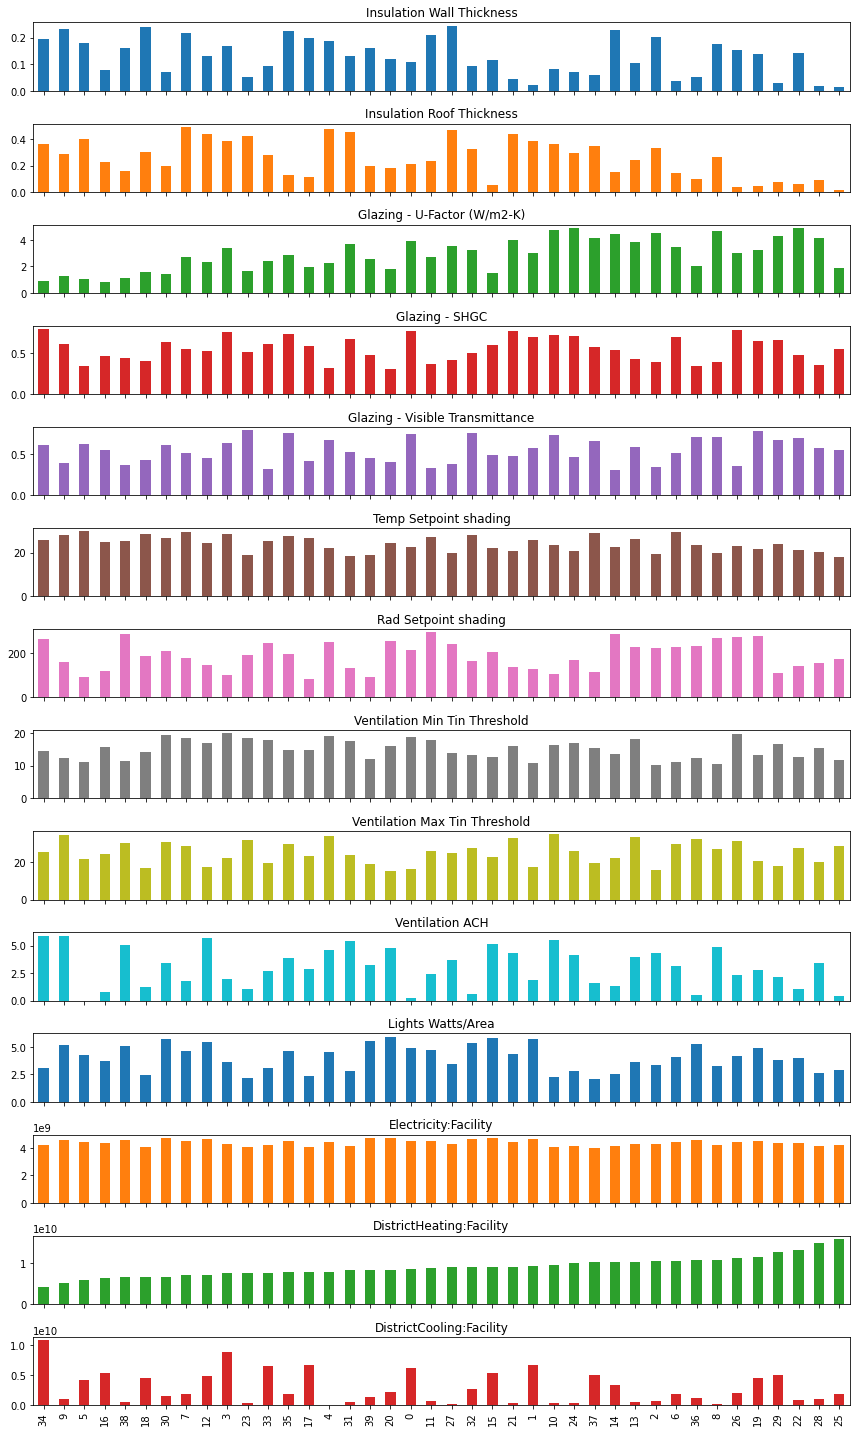

In [25]:
sim_samples = sim_samples.sort_values(by=objectives[1]) # sort by DistrictCooling:Facility
ax = sim_samples.plot.bar(subplots=True, legend=None, figsize=(12, 20))
plt.tight_layout()
plt.show()

## Visualising the parametric analysis

A better way to analyse the results is by looking at scatter plots of the inputs versus the outputs.  
This enables us to visually see strong relationships of inputs and outputs.


Generating plot part 1 with parameters: ['Insulation Wall Thickness', 'Insulation Roof Thickness', 'Glazing - U-Factor (W/m2-K)', 'Glazing - SHGC']


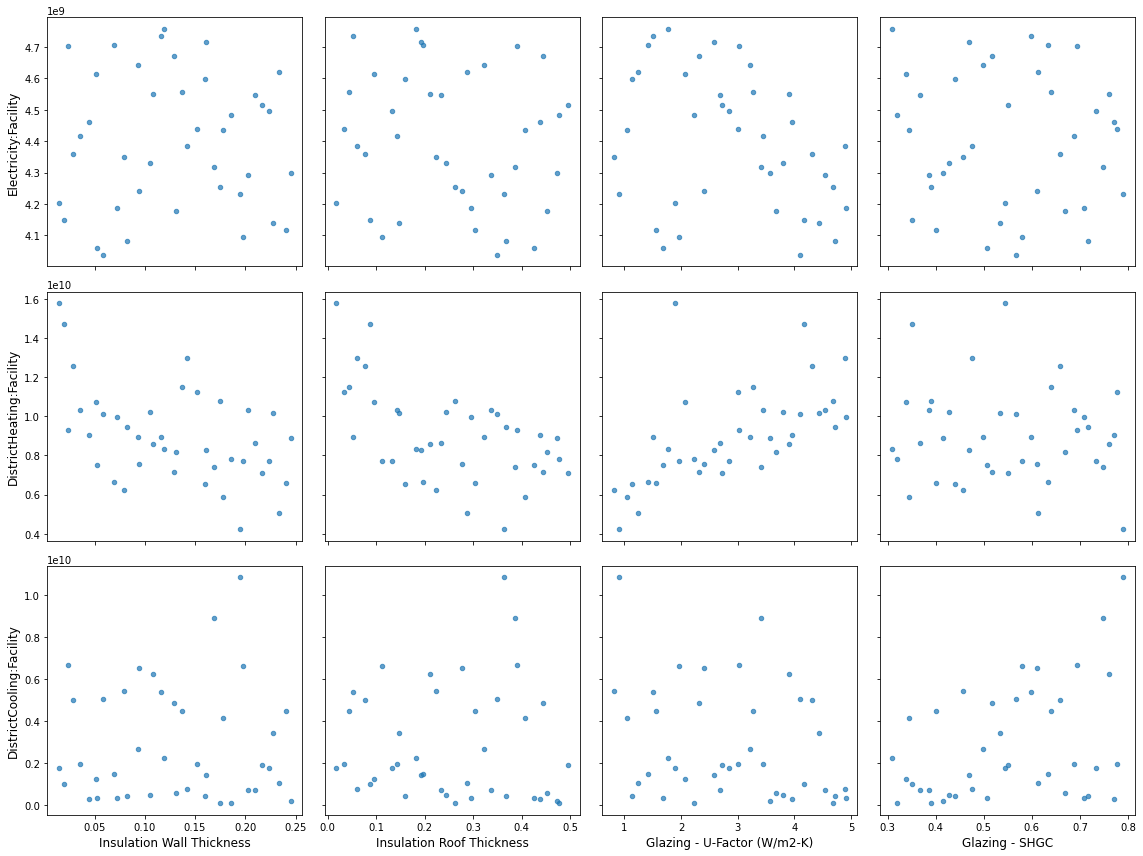


Generating plot part 2 with parameters: ['Glazing - Visible Transmittance', 'Temp Setpoint shading', 'Rad Setpoint shading', 'Ventilation Min Tin Threshold']


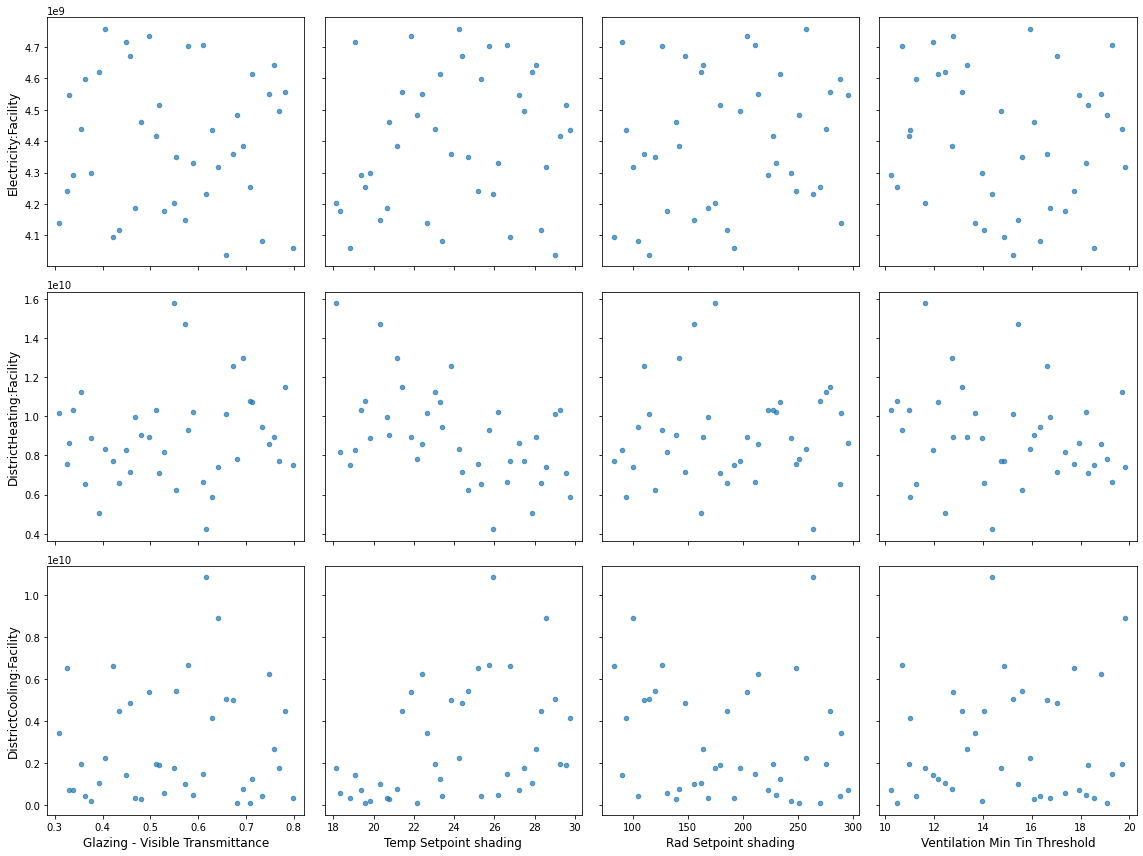


Generating plot part 3 with parameters: ['Ventilation Max Tin Threshold', 'Ventilation ACH', 'Lights Watts/Area']


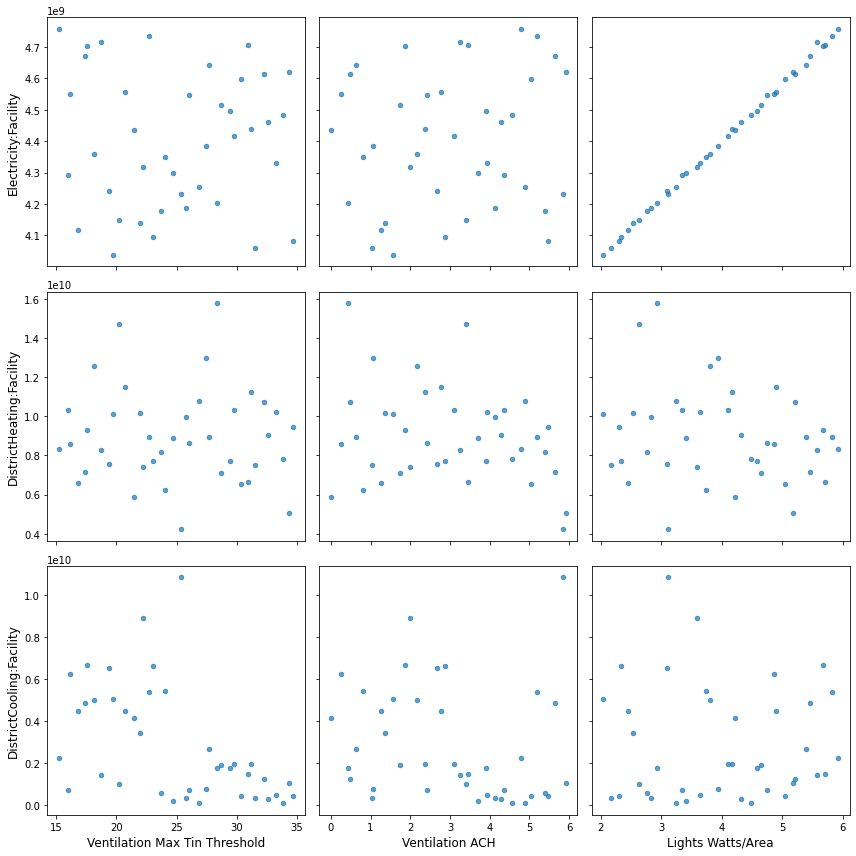

In [26]:
# Plot pairplot

# Get the list of all x-variables
all_x_vars = samples.columns.tolist()
num_x_vars = len(all_x_vars)
num_objectives = len(objectives)

def plot_pairgrid(samples, objectives, all_x_vars, cols_per_plot=4, unit_size=4):
    """Plot pairgrid of objectives vs parameters in chunks.

    Args:
        samples (DataFrame): DataFrame containing simulation samples.
        objectives (list): List of objective variable names.
        all_x_vars (list): List of all parameter variable names.
        cols_per_plot (int): Number of columns per plot grid.
        unit_size (int): Size of each plot unit in inches.

    Returns:
        None
    """
    # Loop through the x-variables, generating a new plot grid for each chunk
    for i in range(0, num_x_vars, cols_per_plot):
        current_x_vars = all_x_vars[i:i + cols_per_plot]
        current_cols = len(current_x_vars)
        
        print(f"\nGenerating plot part {i//cols_per_plot + 1} with parameters: {current_x_vars}")

        # Create the figure and the grid of axes (Rows = Objectives, Columns = current_x_vars)
        fig, axes = plt.subplots(
            num_objectives, 
            current_cols, 
            figsize=(current_cols * unit_size, num_objectives * unit_size)
        )

        # Ensure axes is always a 2D array
        if num_objectives == 1:
            axes = np.array([axes])
        if current_cols == 1:
            axes = np.array(axes).reshape(-1, 1)

        # Nested loops for plotting: Iterate over Objectives (Rows) and Parameters (Columns)
        for row in range(num_objectives):
            for col in range(current_cols):
                ax = axes[row, col]
                x_var = current_x_vars[col]
                y_var = objectives[row]

                # --- Scatter Plot ---
                ax.scatter(samples[x_var], samples[y_var], alpha=0.7, s=20)
                
                # --- Axis Labeling and Cleanup ---
                
                # Label the X-axis (Parameter name) only on the bottom row
                if row == num_objectives - 1:
                    ax.set_xlabel(x_var, fontsize=12)
                else:
                    ax.set_xticklabels([])
                
                # Label the Y-axis (Objective name) only on the first column
                if col == 0:
                    ax.set_ylabel(y_var, fontsize=12)
                else:
                    ax.set_yticklabels([])
        
        # Apply tight layout
        plt.tight_layout()
        plt.show()

plot_pairgrid(sim_samples, objectives, all_x_vars, cols_per_plot=4, unit_size=4)

### Correlation heat map
Another way to analyse the impact of the inputs on the outputs is by analysing the correlation.  
A common metric is the Pearsson correlation coefficient:

$ r = \frac{N\sum{XY}-(\sum{X}\sum{Y})}{\sqrt{ [N\sum{x^2}-(\sum{x})^2 ][N\sum{y^2}-(\sum{y})^2 }]} $

where N is the number of samples. $X$ is the vector of observation of variable 1 (e.g. wall conductivity) and $Y$ is the vetor of observations of variable 2 (e.g. electricity consumption).  
The closer $r$ is to one the stronger the correlation, and similarly for negative one and negative correleation.

To visualize the correlation coefficients of all inputs and outputs, we can plot a heatmap:

In [27]:
print("Columns in 'sim_samples':")
print(list(sim_samples.columns))

# Extract features
features = list(samples.columns)
print("Features extracted:")
print(features)

# Print objectives
print("Objectives:")
print(objectives)

Columns in 'sim_samples':
['Insulation Wall Thickness', 'Insulation Roof Thickness', 'Glazing - U-Factor (W/m2-K)', 'Glazing - SHGC', 'Glazing - Visible Transmittance', 'Temp Setpoint shading', 'Rad Setpoint shading', 'Ventilation Min Tin Threshold', 'Ventilation Max Tin Threshold', 'Ventilation ACH', 'Lights Watts/Area', 'Electricity:Facility', 'DistrictHeating:Facility', 'DistrictCooling:Facility']
Features extracted:
['Insulation Wall Thickness', 'Insulation Roof Thickness', 'Glazing - U-Factor (W/m2-K)', 'Glazing - SHGC', 'Glazing - Visible Transmittance', 'Temp Setpoint shading', 'Rad Setpoint shading', 'Ventilation Min Tin Threshold', 'Ventilation Max Tin Threshold', 'Ventilation ACH', 'Lights Watts/Area']
Objectives:
['Electricity:Facility', 'DistrictHeating:Facility', 'DistrictCooling:Facility']


In [28]:
corr = sim_samples.corr()
corr

Insulation Wall Thickness  \
Insulation Wall Thickness                         1.000000   
Insulation Roof Thickness                         0.209126   
Glazing - U-Factor (W/m2-K)                      -0.156110   
Glazing - SHGC                                   -0.190180   
Glazing - Visible Transmittance                  -0.348287   
Temp Setpoint shading                             0.198994   
Rad Setpoint shading                              0.275496   
Ventilation Min Tin Threshold                    -0.052759   
Ventilation Max Tin Threshold                    -0.035662   
Ventilation ACH                                   0.214749   
Lights Watts/Area                                 0.005648   
Electricity:Facility                              0.014769   
DistrictHeating:Facility                         -0.480124   
DistrictCooling:Facility                          0.013491   

                                 Insulation Roof Thickness  \
Insulation Wall Thickness                         0.209126   
Insulation Roof Thickness                         1.000000   
Glazing - U-Factor (W/m2-K)                      -0.000336   
Glazing - SHGC                                   -0.016422   
Glazing - Visible Transmittance                   0.011452   
Temp Setpoint shading                             0.126611   
Rad Setpoint shading                             -0.208889   
Ventilation Min Tin Threshold                     0.237838   
Ventilation Max Tin Threshold                     0.037129   
Ventilation ACH                                   0.192300   
Lights Watts/Area                                -0.131518   
Electricity:Facility                             -0.130793   
DistrictHeating:Facility                         -0.538449   
DistrictCooling:Facility                         -0.012218   

                                 Glazing - U-Factor (W/m2-K)  Glazing - SHGC  \
Insulation Wall Thickness                          -0.156110       -0.190180   
Insulation Roof Thickness                          -0.000336       -0.016422   
Glazing - U-Factor (W/m2-K)                         1.000000        0.178515   
Glazing - SHGC                                      0.178515        1.000000   
Glazing - Visible Transmittance                     0.140911        0.141766   
Temp Setpoint shading                              -0.329344        0.090534   
Rad Setpoint shading                               -0.072498       -0.186325   
Ventilation Min Tin Threshold                       0.042977        0.268672   
Ventilation Max Tin Threshold                      -0.081788        0.104343   
Ventilation ACH                                     0.017122        0.125058   
Lights Watts/Area                                  -0.337541       -0.062737   
Electricity:Facility                               -0.338326       -0.068723   
DistrictHeating:Facility                            0.601875       -0.083636   
DistrictCooling:Facility                           -0.280694        0.391462   

                                 Glazing - Visible Transmittance  \
Insulation Wall Thickness                              -0.348287   
Insulation Roof Thickness                               0.011452   
Glazing - U-Factor (W/m2-K)                             0.140911   
Glazing - SHGC                                          0.141766   
Glazing - Visible Transmittance                         1.000000   
Temp Setpoint shading                                  -0.007472   
Rad Setpoint shading                                   -0.234079   
Ventilation Min Tin Threshold                           0.066015   
Ventilation Max Tin Threshold                           0.204288   
Ventilation ACH                                        -0.260751   
Lights Watts/Area                                      -0.005434   
Electricity:Facility                                   -0.032928   
DistrictHeating:Facility                                0.146706   
DistrictCooling:Fa

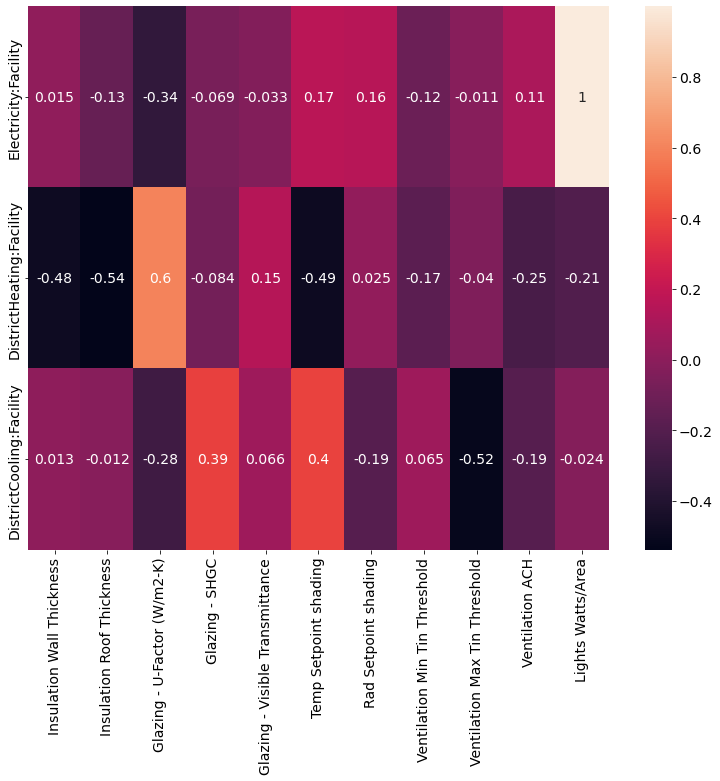

In [29]:
corr.drop(objectives, axis=1, inplace=True)      
corr.drop(features, axis=0, inplace=True)   

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(13, 10)) 

_ = heatmap(corr, annot=True)

# Setup the dataset for the Surrogate Model

In [30]:
y = sim_samples[objectives]
x = sim_samples.drop(columns=objectives)

## Train-test split

Next we split the data into a training set (80%) and a testing set (20%).

In [31]:
train_in, test_in, train_out, test_out = train_test_split(x, y, test_size=0.2)

## Normalization of inputs

To ensure an equal weighting of inputs and outputs in the backpropagation algorithm fitting the neural network, we have to normalize the input values.
For example window-to-wall ratio is in the range of 0 to 1 while the W/$m^2$ are in a range of 10 to 15.
Different options for normalization exist.
Here we bring all features (input variables) to have zero mean and a standarddeviation of 1.
Note that we fit the normalizer on training data only.

In [32]:
scaler = StandardScaler()
train_in_scale = scaler.fit_transform(X=train_in)
test_in_scale = scaler.fit_transform(X=test_in)

scaler_out = StandardScaler()
train_out_scale = scaler_out.fit_transform(X=train_out)
test_out_scale = scaler_out.fit_transform(X=test_out)

# Neural Network

## Hyper-parameters

Before we start fitting the NN model we define the set of hyperparameters we want to analyse in our cross-validation to optimize the model.
Here, we select the number of layers of the network as well as the regularization parameter alpha as parameter value.
A larger number of layers and a lower value of the regularizer lead to higher variance of the network.
This may lead to overfitting.
The best selection may be found using an optimizer like Bayesian Optimization.
In this example we use a simple grid search.

In [33]:
hyperparameters = {
    "hidden_layer_sizes": (
        (len(parameters) * 16,),
        (len(parameters) * 16, len(parameters) * 16),
    ),
    "alpha": [1, 10, 10 ** 3],
}

neural_net = MLPRegressor(max_iter=1000, early_stopping=False)
folds = 3

## Model fitting

Here, we use the NN model from ScikitLearn.


In [ ]:
clf = GridSearchCV(neural_net, hyperparameters, cv=folds)
clf.fit(train_in_scale, train_out_scale)

nn_model = clf.best_estimator_

print("Best Hyperparameters Found:")
print(clf.best_params_)

In [35]:
prediction_nn_scaled = nn_model.predict(test_in_scale)
prediction_nn = scaler_out.inverse_transform(prediction_nn_scaled)
print("Predictions:", prediction_nn)

Predictions: [[4.51620099e+09 7.97811337e+09 5.10329137e+08]
 [4.75025659e+09 8.00622869e+09 2.42696506e+09]
 [4.14777656e+09 8.89834459e+09 8.14436327e+07]
 [4.20194697e+09 8.19573122e+09 5.58067541e+09]
 [4.09051956e+09 8.75522082e+09 2.84126503e+09]
 [4.68353715e+09 8.28207929e+09 4.79899740e+09]
 [4.49709643e+09 7.65094073e+09 4.06486803e+09]
 [4.75351862e+09 8.46823310e+09 2.39246206e+09]]


In [ ]:
print("Model NRMSE:")
nrmse = mean_squared_error(prediction_nn, test_out.values, multioutput='raw_values', squared=False) / test_out.mean() * 100
print(nrmse)

print("\nModel R2 SCORE:")
r2 = r2_score(test_out.values, prediction_nn, multioutput='raw_values')
print(r2)

Electricity:Facility        2.511655e+07
DistrictHeating:Facility    6.054487e+09
DistrictCooling:Facility    1.049521e+11
dtype: float64

## Surrogate Modelling Evaluator object
We can wrap the fitted model in a BESOS `Evaluator`.

In [40]:
# Definition of the evaluation function
def evaluation_func(ind, scaler=scaler):
    # Scale the input using the scaler
    ind = scaler.transform(X=[ind])
    # Predict using the model
    prediction = nn_model.predict(ind)
    # Inverse scale and return as a list
    return scaler_out.inverse_transform(prediction)[0].tolist()

evaluator = EvaluatorGeneric(evaluation_func, problem)

srinputs = sampling.dist_sampler(sampling.lhs, problem, 500)
srinputs

Insulation Wall Thickness  Insulation Roof Thickness  \
0                     0.029473                   0.257949   
1                     0.171690                   0.410655   
2                     0.230316                   0.302061   
3                     0.167082                   0.328767   
4                     0.230706                   0.226501   
..                         ...                        ...   
495                   0.061209                   0.063868   
496                   0.113510                   0.050506   
497                   0.076603                   0.216698   
498                   0.212857                   0.088284   
499                   0.105362                   0.116233   

     Glazing - U-Factor (W/m2-K)  Glazing - SHGC  \
0                       2.914778        0.771221   
1                       2.039120        0.307452   
2                       4.456187        0.693974   
3                       2.884706        0.382072   
4                       4.878131        0.362759   
..                           ...             ...   
495                     1.151530        0.472606   
496                     3.212341        0.380248   
497                     4.911932        0.691027   
498                     1.912252        0.786621   
499                     1.272248        0.558037   

     Glazing - Visible Transmittance  Temp Setpoint shading  \
0                           0.787357              25.647683   
1                           0.487063              19.790378   
2                           0.648923              25.860181   
3                           0.488476              26.646396   
4                           0.586502              28.693970   
..                               ...                    ...   
495                         0.338544              20.153217   
496                         0.329520              20.881969   
497                         0.756311              27.631399   
498                         0.707487              29.841630   
499                         0.696478              28.789053   

     Rad Setpoint shading  Ventilation Min Tin Threshold  \
0              104.387013                      13.134469   
1              287.131589                      16.922749   
2              257.188455                      10.943410   
3              252.986869                      14.840979   
4              164.281600                      14.133913   
..                    ...                            ...   
495            238.321418                      11.785355   
496            147.707853                      13.707278   
497            221.926894                      16.520076   
498            159.703218                      14.276448   
499            217.485563                      19.379490   

     Ventilation Max Tin Threshold  Ventilation ACH  Lights Watts/Area  
0                        17.236983         0.788181           2.794036  
1                        15.615030         2.018292           3.642074  
2                        17.683788         2.965221           4.551358  
3                        23.180647         1.856302           3.152235  
4                        31.573352         2.729451           5.201565  
..                             ...              ...                ...  
495                      23.382518         3.645705           3.947121  
496                      29.601749         2.847746           4.377676  
497                      19.481300         1.886098           4.940596  
498                      30.568657         0.467907           5.488039  
499                      31.413749         0.701013           2.415392  

[500 rows x 11 columns]

In [41]:
sroutputs = evaluator.df_apply(srinputs)
srresults = srinputs.join(sroutputs)
srresults.head()

Executing:   0%|          | 0/500 [00:00<?, ?row/s]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py

Insulation Wall Thickness  Insulation Roof Thickness  \
0                   0.029473                   0.257949   
1                   0.171690                   0.410655   
2                   0.230316                   0.302061   
3                   0.167082                   0.328767   
4                   0.230706                   0.226501   

   Glazing - U-Factor (W/m2-K)  Glazing - SHGC  \
0                     2.914778        0.771221   
1                     2.039120        0.307452   
2                     4.456187        0.693974   
3                     2.884706        0.382072   
4                     4.878131        0.362759   

   Glazing - Visible Transmittance  Temp Setpoint shading  \
0                         0.787357              25.647683   
1                         0.487063              19.790378   
2                         0.648923              25.860181   
3                         0.488476              26.646396   
4                         0.586502              28.693970   

   Rad Setpoint shading  Ventilation Min Tin Threshold  \
0            104.387013                      13.134469   
1            287.131589                      16.922749   
2            257.188455                      10.943410   
3            252.986869                      14.840979   
4            164.281600                      14.133913   

   Ventilation Max Tin Threshold  Ventilation ACH  Lights Watts/Area  \
0                      17.236983         0.788181           2.794036   
1                      15.615030         2.018292           3.642074   
2                      17.683788         2.965221           4.551358   
3                      23.180647         1.856302           3.152235   
4                      31.573352         2.729451           5.201565   

   Electricity:Facility  DistrictHeating:Facility  DistrictCooling:Facility  
0          4.189249e+09              8.906218e+09              6.882616e+09  
1          4.344006e+09              8.267555e+09              2.642703e+09  
2          4.484239e+09              8.265346e+09              4.158968e+09  
3          4.249594e+09              8.266333e+09              2.895057e+09  
4          4.599208e+09              8.484540e+09              3.497592e+08

## Exploration

In [42]:
plotly.offline.init_notebook_mode(connected=True)

In [ ]:
fig = px.parallel_coordinates(
    srresults, color="Electricity:Facility",
    dimensions=features + objectives,
    color_continuous_scale=px.colors.diverging.Tealrose
)

fig.update_layout(
    width=1300,
    height=600,
    margin=dict(l=80, r=80, t=50, b=50)
)

fig.show()

# Perform Building Optimization 

Using the best surrogate perform an otimization process, select optimal values and save a new idf with the selected values. Evalute the goodnes of the surrogate simuation with EnergyPlus.

In [44]:
# Running NSGA-II optimizator 
results = NSGAII(evaluator, evaluations=5000, population_size=10000)

opt_res = results.loc[results["pareto-optimal"] == True, :]  # Get only the optimal results
opt_res

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler

Insulation Wall Thickness  Insulation Roof Thickness  \
20                     0.048568                   0.211187   
84                     0.043802                   0.191279   
129                    0.183544                   0.346070   
200                    0.140875                   0.412138   
202                    0.209966                   0.490886   
...                         ...                        ...   
9808                   0.163788                   0.384908   
9828                   0.205295                   0.368873   
9867                   0.020672                   0.487447   
9971                   0.181828                   0.364648   
9993                   0.064647                   0.387800   

      Glazing - U-Factor (W/m2-K)  Glazing - SHGC  \
20                       4.944686        0.342471   
84                       1.041457        0.418657   
129                      1.908653        0.526882   
200                      3.886267        0.595574   
202                      2.108559        0.779965   
...                           ...             ...   
9808                     2.006616        0.485893   
9828                     1.087630        0.533384   
9867                     1.397993        0.437263   
9971                     1.850951        0.652132   
9993                     1.861150        0.352638   

      Glazing - Visible Transmittance  Temp Setpoint shading  \
20                           0.354297              18.095068   
84                           0.465408              18.625750   
129                          0.320749              28.759526   
200                          0.470011              29.222928   
202                          0.372474              29.400124   
...                               ...                    ...   
9808                         0.481490              19.719884   
9828                         0.594409              29.155444   
9867                         0.542778              18.625464   
9971                         0.571605              27.954036   
9993                         0.451815              27.417827   

      Rad Setpoint shading  Ventilation Min Tin Threshold  \
20              152.415021                      11.220498   
84              161.467344                      12.218621   
129             138.345948                      14.695560   
200             106.372115                      15.236833   
202             150.181328                      10.723616   
...                    ...                            ...   
9808            117.679284                      10.915003   
9828            130.574909                      10.756013   
9867             94.555307                      15.402434   
9971            130.861968                      12.685368   
9993             85.376842                      17.489670   

      Ventilation Max Tin Threshold  Ventilation ACH  Lights Watts/Area  \
20                        31.901422         5.783211           3.396445   
84                        26.640955         3.138773           2.083639   
129                       25.902883         5.365744           2.720989   
200                       20.567247         2.371006           2.019032   
202                       22.443026         5.766015           2.059170   
...                             ...              ...                ...   
9808                      17.831834         3.037443           2.009664   
9828                      29.299233         2.939902           5.681749   
9867                      34.979413         5.501364           4.519485   
9971                      32.000951         4.977447           4.798682   
9993                      17.814931         0.706145           2.080480   

      Electricity:Facility  DistrictHeating:Facility  \
20            4.226809e+09              9.712965e+09   
84            4.062954e+09              9.288212e+09   
129           4.191867e+09              7.321265e+09 

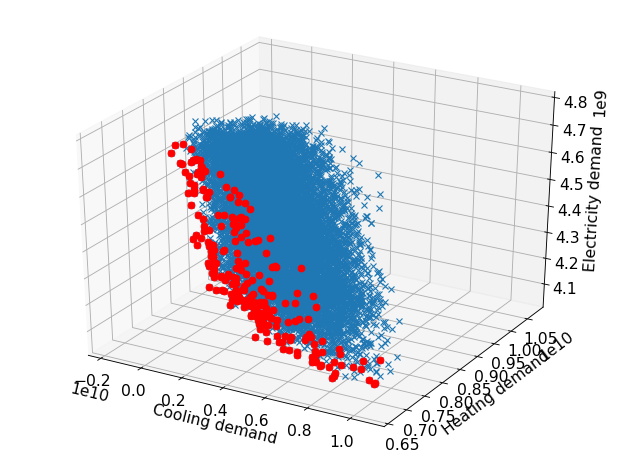

In [45]:
# Plot the results
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')

df = pd.DataFrame(opt_res, columns=features + objectives)

ax.plot3D(
    results["DistrictCooling:Facility"],
    results["DistrictHeating:Facility"],
    results["Electricity:Facility"], "x"
)  # plot all results in the background as blue crosses

ax.plot3D(
    opt_res["DistrictCooling:Facility"],
    opt_res["DistrictHeating:Facility"],
    opt_res["Electricity:Facility"],
    "ro"
)  # plot optimal results in red

ax.set_xlabel("Cooling demand")
ax.set_ylabel("Heating demand")
ax.set_zlabel("Electricity demand")
plt.tight_layout()
plt.show()


Generating plot part 1 with parameters: ['Insulation Wall Thickness', 'Insulation Roof Thickness', 'Glazing - U-Factor (W/m2-K)', 'Glazing - SHGC']


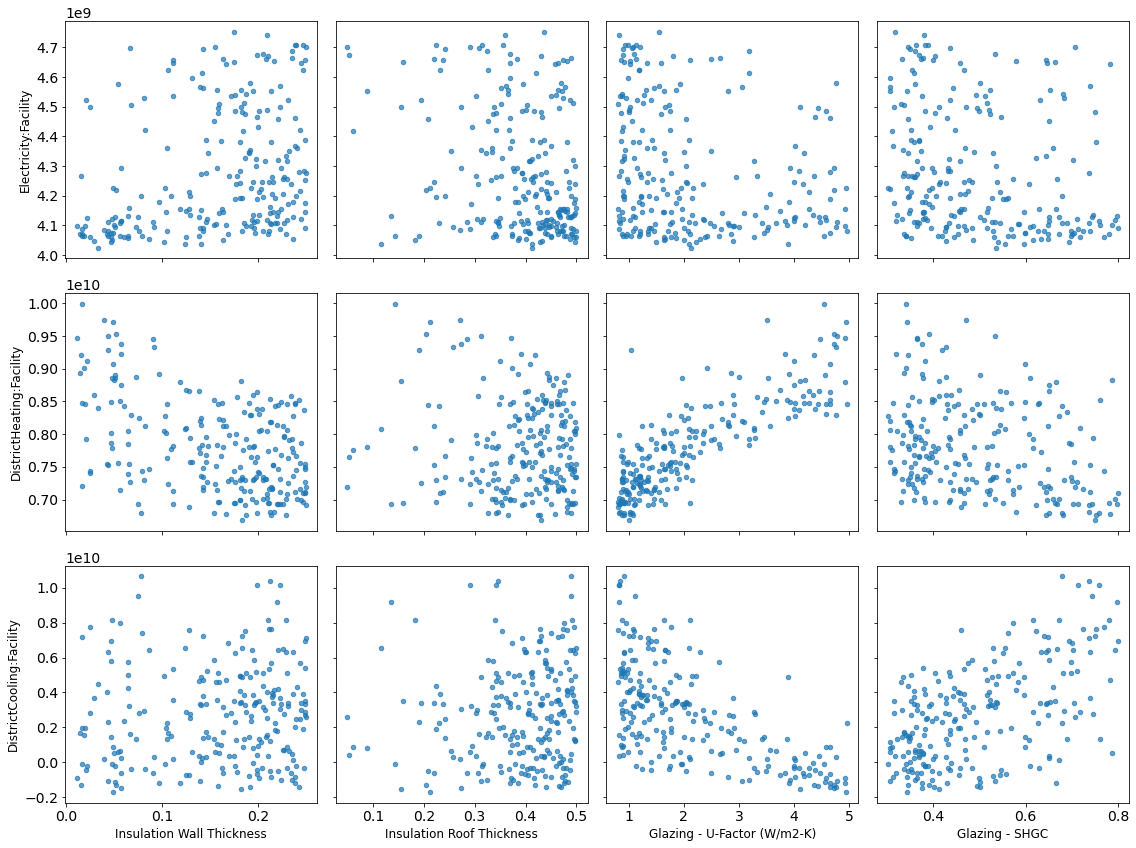


Generating plot part 2 with parameters: ['Glazing - Visible Transmittance', 'Temp Setpoint shading', 'Rad Setpoint shading', 'Ventilation Min Tin Threshold']


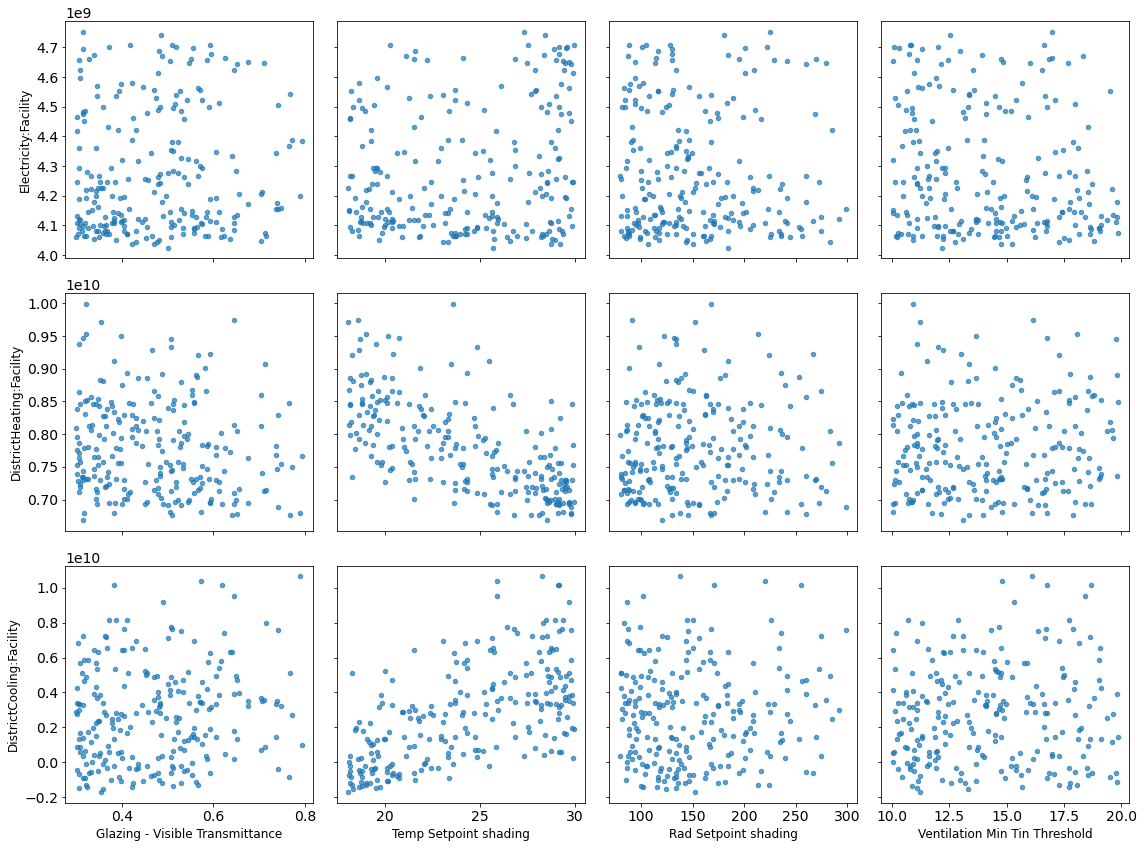


Generating plot part 3 with parameters: ['Ventilation Max Tin Threshold', 'Ventilation ACH', 'Lights Watts/Area']


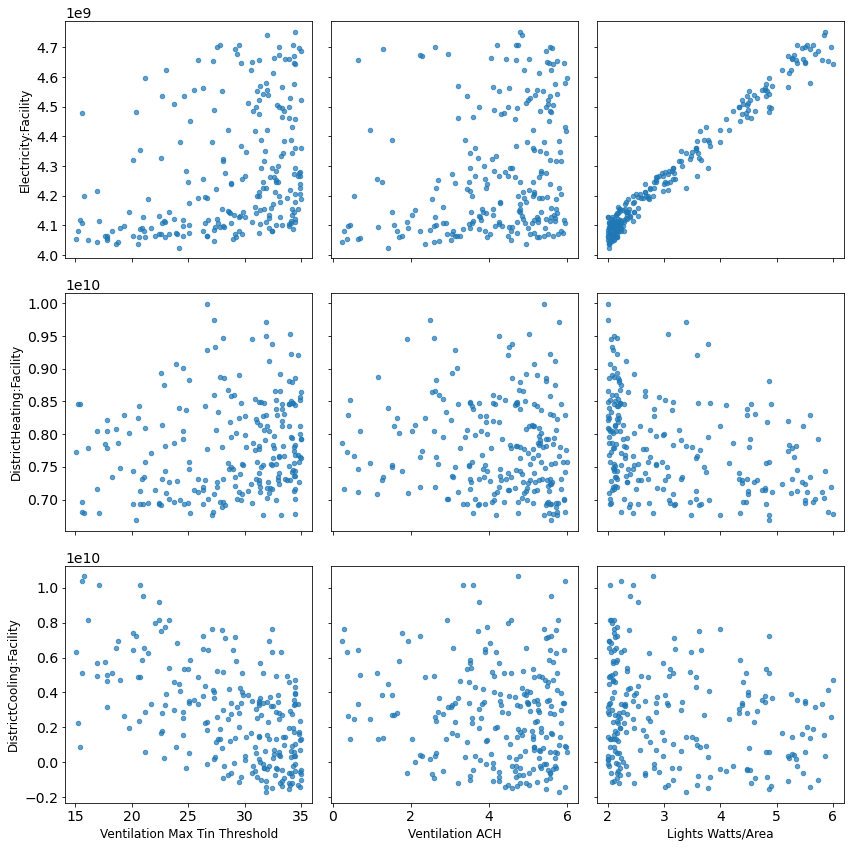

In [46]:
# Plot pairplot of the optimal results
plot_pairgrid(opt_res, objectives, all_x_vars, cols_per_plot=4, unit_size=4)

In [47]:
# Compute the correlation matrix
corr = opt_res.corr()

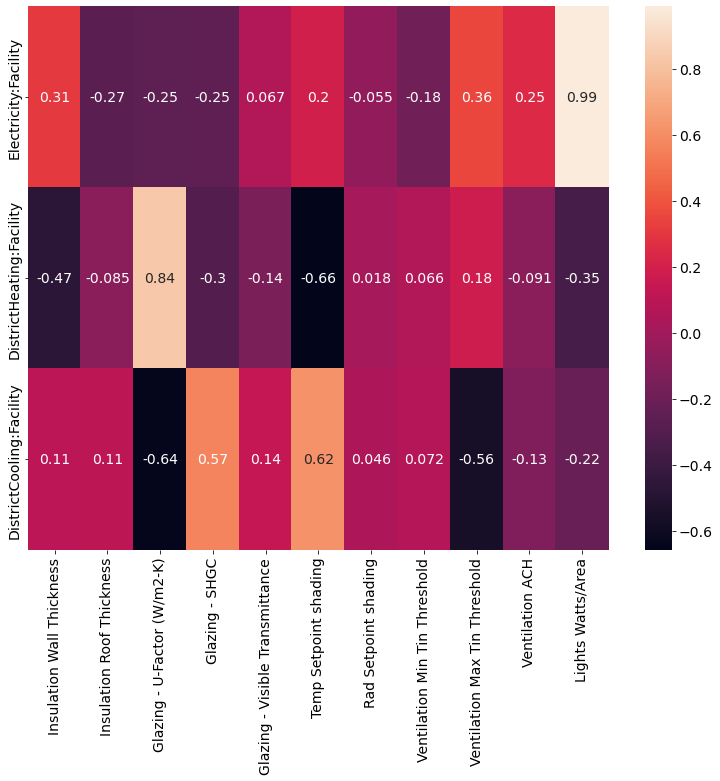

In [48]:
# Variables to exclude from the correlation heatmap
unuseful = ['violation', 'pareto-optimal']

# Drop unwanted objectives and features from the correlation matrix
corr.drop(objectives + unuseful, axis = 1, inplace = True)
corr.drop(features + unuseful, axis = 0 ,inplace = True)
corr

# Plotting the refined correlation heatmap
plt.figure(figsize=(13, 10))
_ = heatmap(corr, annot=True)

Select the optimal parameters and outputs

In [ ]:
def calculate_total_primary_energy(simulation_outputs):
    """
    Calculates the total primary energy from simulation outputs.
    
    Args:
        simulation_outputs (dict): A dictionary containing the simulation outputs.
    
    Returns:
        float: Total primary energy.
    """
    # Get NET ENERGY from simulation outputs
    Q_H_net = simulation_outputs['DistrictHeating:Facility'] 
    Q_C_net = simulation_outputs['DistrictCooling:Facility']
    Q_light_net = simulation_outputs['Electricity:Facility']
    
    # Conversion: NET to FINAL ENERGY (Q_final)
    # ASSUME: Heating is Gas Boiler (COP=0.98), Cooling is split-electric (EER=5.4), Lighting is Electric
    # - Heating Final
    COP_H = 0.98  
    Q_H_final = Q_H_net / COP_H
    
    # - Cooling Final
    EER_C = 5.4  
    Q_C_final = Q_C_net / EER_C
    
    # - Lighting Final
    Q_light_final = Q_light_net
    
    # Conversion: FINAL to PRIMARY ENERGY (Q_PE)
    # PE Factors based on source
    PE_gas = 1.00
    PE_electricity = 2.17
    # - Heating Primary
    Q_H_PE = Q_H_final * PE_gas
    # - Cooling Primary
    Q_C_PE = Q_C_final * PE_electricity
    # - Lighting Primary
    Q_light_PE = Q_light_final * PE_electricity
    
    # Total PRIMARY ENERGY
    Q_total_PE = Q_H_PE + Q_C_PE + Q_light_PE
    
    return Q_total_PE

# Compute the total Primary Energy for every row
df['Q_Total_PE'] = df.apply(calculate_total_primary_energy, axis=1)

# Find the index that corresponds to the minimum Primary Energy value
min_pe_index = df['Q_Total_PE'].idxmin()

# Extract the optimal row
optimal_row = df.loc[min_pe_index]

print("Optimal Values:")
print(optimal_row)

Optimal Values:


Insulation Wall Thickness  Insulation Roof Thickness  \
9791                   0.209057                   0.359155   

      Glazing - U-Factor (W/m2-K)  Glazing - SHGC  \
9791                     0.818695        0.380224   

      Glazing - Visible Transmittance  Temp Setpoint shading  \
9791                         0.484619              28.468421   

      Rad Setpoint shading  Ventilation Min Tin Threshold  \
9791            180.217274                      12.531516   

      Ventilation Max Tin Threshold  Ventilation ACH  Lights Watts/Area  \
9791                      31.951878         4.847872           5.835484   

      Electricity:Facility  DistrictHeating:Facility  \
9791          4.740860e+09              7.019325e+09   

      DistrictCooling:Facility         Total          Dist  
9791              1.564028e+09  1.332421e+10  8.613528e+09

Identify best building design parameters and save the new idf

In [ ]:
optimal_params = optimal_row[features].to_dict()
optimal_outputs = optimal_row[objectives].to_dict()
optimal_total_pe = optimal_row['Q_Total_PE']

print("Optimal Parameters:", optimal_params)
print("Optimal Outputs:", optimal_outputs)
print("Total primary energy of the optimal solution:", optimal_total_pe)

Optimal Parameters: {'Insulation Wall Thickness': 0.20905696086689188, 'Insulation Roof Thickness': 0.3591548693467439, 'Glazing - U-Factor (W/m2-K)': 0.8186948591602831, 'Glazing - SHGC': 0.38022417443698087, 'Glazing - Visible Transmittance': 0.4846187921633439, 'Temp Setpoint shading': 28.46842112834995, 'Rad Setpoint shading': 180.2172743577131, 'Ventilation Min Tin Threshold': 12.531516322578359, 'Ventilation Max Tin Threshold': 31.951877703542685, 'Ventilation ACH': 4.847872399790617, 'Lights Watts/Area': 5.835484068574006}
Optimal Outputs: {'Electricity:Facility': 4740859639.337443, 'DistrictHeating:Facility': 7019325261.592495, 'DistrictCooling:Facility': 1564028061.6492634}


In [51]:
# Selection of the optimal parameters
insulation_wall_selector.set(building, optimal_params['Insulation Wall Thickness'])
insulation_roof_selector.set(building, optimal_params['Insulation Roof Thickness'])
u_factor_selector.set(building, optimal_params['Glazing - U-Factor (W/m2-K)'])
shgc_selector.set(building, optimal_params['Glazing - SHGC'])
visible_transmittance_selector.set(building, optimal_params['Glazing - Visible Transmittance'])
shade_temp_selector.set(building, optimal_params['Temp Setpoint shading'])
shade_rad_selector.set(building, optimal_params['Rad Setpoint shading'])
vent_tin_min_selector.set(building, optimal_params['Ventilation Min Tin Threshold'])
vent_tin_max_selector.set(building, optimal_params['Ventilation Max Tin Threshold'])
ventACH_selector.set(building, optimal_params['Ventilation ACH'])
lights_selector.set(building, optimal_params['Lights Watts/Area'])

In [ ]:
# Save the optimised building to a new IDF file
building.saveas('res2_optimal.idf')

In [53]:
building.idfobjects['MATERIAL']

[
Material,
    Cast Concrete (Dense)_.1,    !- Name
    Rough,                    !- Roughness
    0.1,                      !- Thickness
    1.4,                      !- Conductivity
    2100,                     !- Density
    840,                      !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
, 
Material,
    Asphalt 1_.01,            !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.7,                      !- Conductivity
    2100,                     !- Density
    1000,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.85,                     !- Solar Absorptance
    0.9;                      !- Visible Absorptance
, 
Material,
    MW Glass Wool (rolls)_.0001,    !- Name
    Rough,                    !- Roughness
    0.3591548693467439,       !- Thickness

Plot the optimal parameters

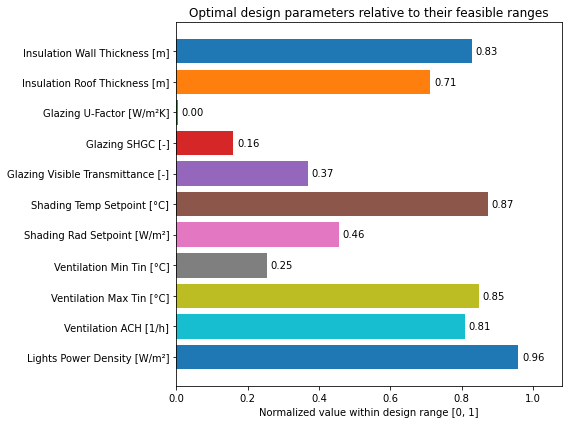

In [65]:
# Parameter keys
param_keys = [
    'Insulation Wall Thickness',
    'Insulation Roof Thickness',
    'Glazing - U-Factor (W/m2-K)',
    'Glazing - SHGC',
    'Glazing - Visible Transmittance',
    'Temp Setpoint shading',
    'Rad Setpoint shading',
    'Ventilation Min Tin Threshold',
    'Ventilation Max Tin Threshold',
    'Ventilation ACH',
    'Lights Watts/Area',
]

# Parameter labels
param_labels = [
    "Insulation Wall Thickness [m]",
    "Insulation Roof Thickness [m]",
    "Glazing U-Factor [W/m²K]",
    "Glazing SHGC [-]",
    "Glazing Visible Transmittance [-]",
    "Shading Temp Setpoint [°C]",
    "Shading Rad Setpoint [W/m²]",
    "Ventilation Min Tin [°C]",
    "Ventilation Max Tin [°C]",
    "Ventilation ACH [1/h]",
    "Lights Power Density [W/m²]",
]

# Parameter ranges
param_bounds = {
    'Insulation Wall Thickness': (0.01, 0.25),
    'Insulation Roof Thickness': (0.01, 0.50),
    'Glazing - U-Factor (W/m2-K)': (0.8, 5.0),
    'Glazing - SHGC': (0.3, 0.8),
    'Glazing - Visible Transmittance': (0.3, 0.8),
    'Temp Setpoint shading': (18.0, 30.0),
    'Rad Setpoint shading': (80.0, 300.0),
    'Ventilation Min Tin Threshold': (10.0, 20.0),
    'Ventilation Max Tin Threshold': (15.0, 35.0),
    'Ventilation ACH': (0.0, 6.0),
    'Lights Watts/Area': (2.0, 6.0),
}

# Extract and normalize the optimal values
norm_vals = []
for key in param_keys:
    p_min, p_max = param_bounds[key]
    v = optimal_params[key]
    norm_vals.append((v - p_min) / (p_max - p_min))

# Define a list of colors
colors = plt.cm.tab10.colors[:len(param_keys)]

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))
y_pos = np.arange(len(param_labels))
ax.barh(y_pos, norm_vals, color=colors)

# Add values at the left of the bars
for i, v in enumerate(norm_vals):
    ax.text(v + 0.01, i, f'{v:.2f}', color='black', va='center', fontsize=10)

ax.set_yticks(y_pos)
ax.set_yticklabels(param_labels)
ax.invert_yaxis()
ax.set_xlim(0, 1.08) # Add some space on the right for text
ax.set_xlabel("Normalized value within design range [0, 1]")
ax.set_title("Optimal design parameters relative to their feasible ranges")
plt.tight_layout()
plt.show()

Plot the optimal outputs and primary energy

Net final primary energy of the optimal solution: 18078749787.827633


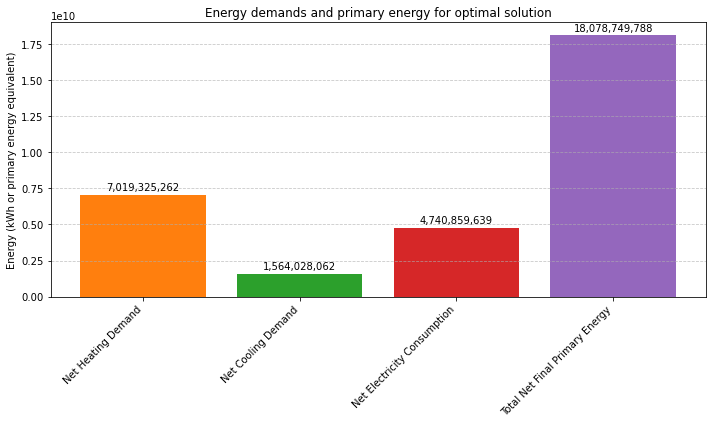

In [ ]:
# --- Data preparation ---
energy_values = [
    optimal_outputs['Electricity:Facility'],
    optimal_outputs['DistrictHeating:Facility'], 
    optimal_outputs['DistrictCooling:Facility']
    optimal_net_final_pe
]
energy_labels = [
    'Net Electricity Consumption',
    'Net Heating Demand', 
    'Net Cooling Demand',
    'Total Primary Energy'
]

# Convert Joules to kWh
J_TO_KWH = 3.6e+6
plot_values_kwh = [v / J_TO_KWH for v in energy_values]

# Define a list of colors
colors = plt.cm.tab10.colors[1:len(plot_values_kwh) + 1]

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(plot_labels, plot_values_kwh, color=colors)

# Add values on top of the bars
for bar in bars:
    yval = bar.get_height()
    offset = max(plot_values_kwh) * 0.01 if plot_values_kwh else 10
    ax.text(bar.get_x() + bar.get_width() / 2.0, yval + offset, 
            f'{yval:,.0f}', ha='center', va='bottom', fontsize=10)

ax.set_title('Energy demands and primary energy for optimal solution')
ax.set_ylabel('Energy (kWh or primary energy equivalent)')
ax.set_xticks(np.arange(len(energy_labels)))
ax.set_xticklabels(energy_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()